In [41]:
from pystencils.session import *
import numpy as np
from matplotlib import patches
import tqdm

In [42]:
r = 26
s = 52
h = 100
l1 = 120
l2 = 120

x = l1+l2+s
y = r+h

domain_size = (x, y)

# create arrays
c_arr = np.zeros(domain_size)
U_arr = np.zeros(domain_size)
D_arr = np.ones(domain_size)

# create fields
c, c_next = ps.fields("c, c_next: [2d]", c=c_arr, c_next=c_arr)
D, U = ps.fields("D, U: [2d]", D=D_arr, U=U_arr)

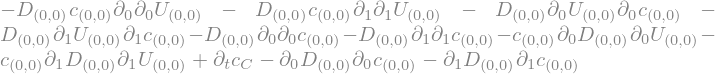

In [43]:
spatial = lambda _axis_: ps.fd.diff(D[0,0]*(ps.fd.diff(c[0,0],_axis_)+c[0,0]*ps.fd.diff(U[0,0],_axis_)),_axis_)
spatial = ps.fd.expand_diff_products(ps.fd.expand_diff_products(spatial(0)+spatial(1)))
temporal = ps.fd.transient(c)
diff_pde = temporal-spatial
diff_pde.simplify()

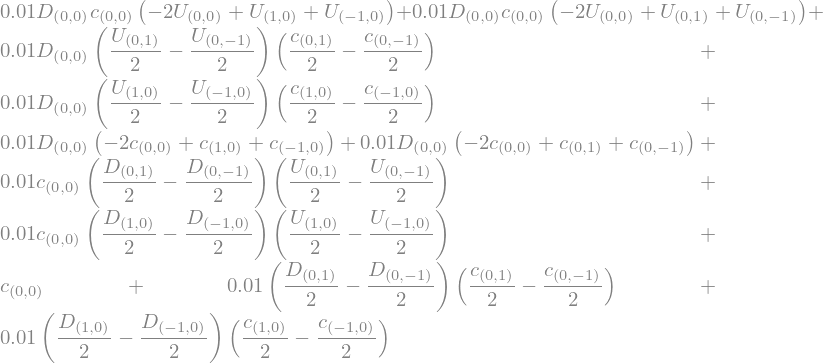

In [44]:
discretization =  ps.fd.Discretization2ndOrder(dx = 1, dt=0.01)(diff_pde.simplify())
discretization

In [45]:
ast = ps.create_kernel([ps.Assignment(c_next[0,0], discretization)])
kernel = ast.compile()

In [49]:
def boundary_handling(c):
    # left inflow border
    c[0, :] = 1.0
    # Reflection boundary at the upper, lower wall
    c[:, 0] = c[:, 1]
    c[:, -1] = c[:, -2]
    # Sink at the outflow border
    c[-1, :] = 0

    #No concentration in the pore walls
    c[l1:l1+s, 0:h] = 0
    # Reflection boundary at the pore walls
    c[l1, 0:h]=c[l1-1, 0:h]
    c[l1+s, 0:h]=c[l1+s+1, 0:h]
    c[l1:l1+s, h] = c[l1:l1+s, h+1]
    


    # Some source inside the domain
    #c[10: 15, 25:30] = 1.0
    #c[20: 25, 60:65] = 1.0

c_tmp_arr = np.empty_like(c_arr)
def timeloop(steps=1000):
    global c_arr, c_tmp_arr
    for i in tqdm.tqdm(steps):
        boundary_handling(c_arr)
        kernel(c=c_arr, c_next=c_tmp_arr, D = D_arr, U=U_arr)
        c_arr, c_tmp_arr = c_tmp_arr, c_arr
    return c_arr

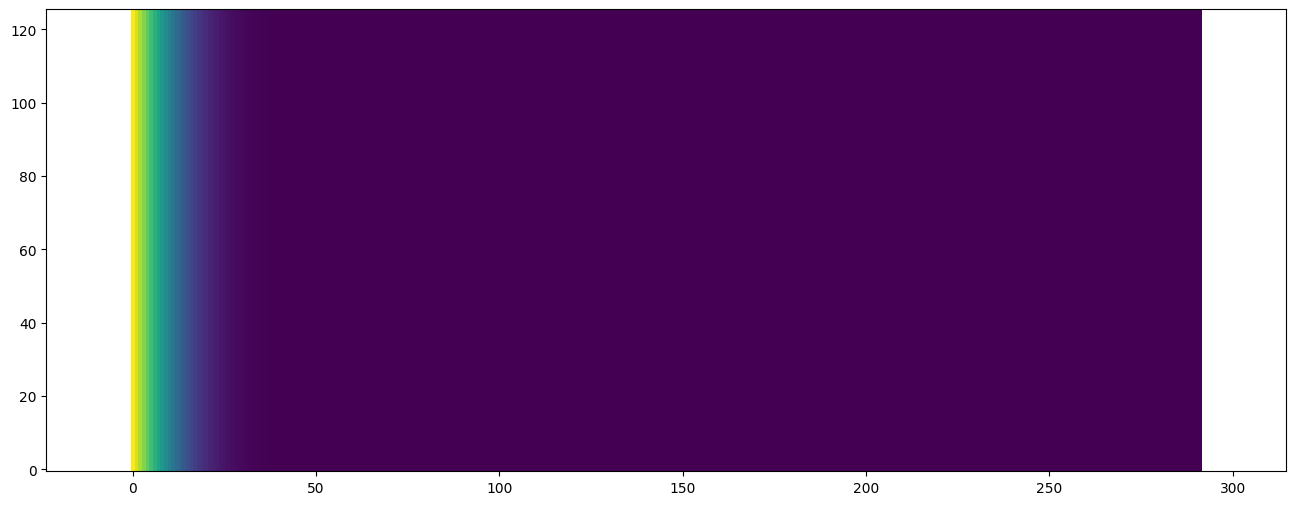

In [50]:
import matplotlib
ani = ps.plot.scalar_field_animation(timeloop, rescale=True, frames=240, interpolation='nearest')

In [51]:
ps.jupyter.display_as_html_video(ani)

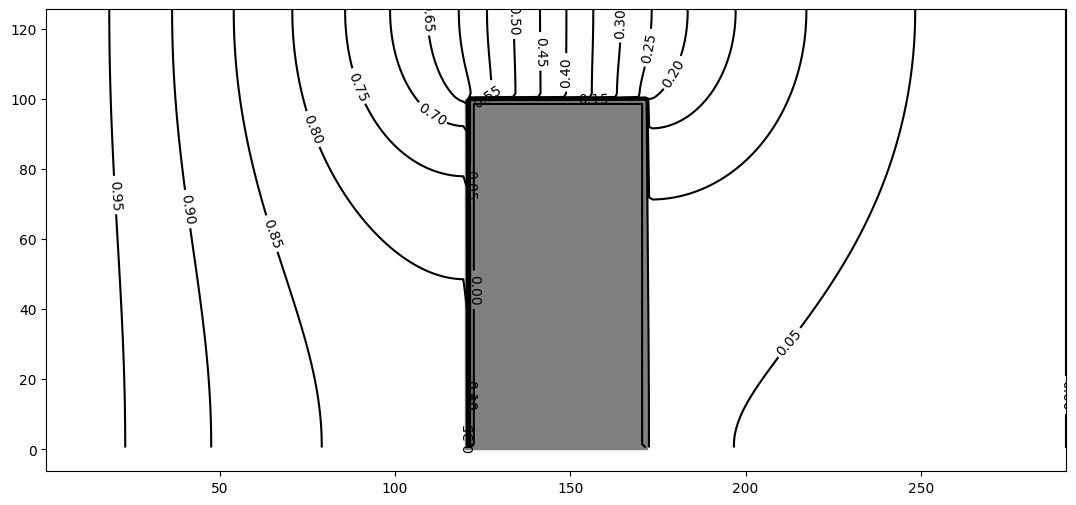

In [58]:
fig, ax  = plt.subplots()
ax.set_aspect('equal')
c = ax.contour(timeloop(1).T, origin = "lower", colors = "black", levels = np.arange(0, 1, 0.05))
ax.clabel(c, inline=True)
rect = patches.Rectangle((l1, 0), s, h, color = "grey")
ax.add_patch(rect)